# Rapid Research Report 1 - Forest Fires
### Trinity Gahagen
---
---

This notebook will deviate from the typical rapid EDAs showcased in the repository. Instead of being timed for only 1-2 hours, this notebook was curated over the course of 12+ hours and created with a focus on employing/improving machine learning models.


Dataset: https://www.kaggle.com/datasets/elikplim/forest-fires-data-set/data

## Dataset Overview
---
From the Kaggle page and research paper it references [Cortez and Morais, 2007], the features in this dataset are:

| Feature |           Description                  |
|---------|----------------------------------------|
|X| x-axis spatial coordinate within the Montesinho park map: 1 to 9 |
|Y| y-axis spatial coordinate within the Montesinho park map: 2 to 9 |
|month| month of the year "jan" to "dec"|
|day| day of the week "mon" to "sun"|
|FFMC| FFMC index from the FWI system 18.7 to 96.20|
|DMC| DMC index from the FWI system 1.1 to 291.3|
|DC| DC index from the FWI system 7.9 to 860.6|
|ISI| ISI index from the FWI system| 0.0 to 56.10|
|temp| temperature in Celsius degrees: 2.2 to 33.30
|RH| relative humidity in % 15.0 to 100|
|wind| wind speed in km/h: 0.40 to 9.40|
|rain| outside rain in mm/m2 : 0.0 to 6.4|
|area| the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).|


`FFMC` - Fine Fuel Moisture Code<br>
>FFMC denotes the moisture content surface litter and influences and fire spread<br>

`DMC` - Duff Moisture Code<br>
`DC` - Drought Code<br>

>the DMC and DC represent the moisture content of shallow and deep organic layers, which affect fire intensity<br>

`ISI` - Initial Spread Index<br>
>a score that correlates with fire velocity spread<br>

### Imports

In [104]:
# System and Operational Importations
import sys, os

# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Plot specifications
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titleweight'] = 'bold'

# Machine Learning tools and metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Machine Learning models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [105]:
forest_fires = pd.read_csv('../data/forestfires.csv')

### Initial Data Exploration

In [106]:
forest_fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [107]:
forest_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [108]:
forest_fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [109]:
forest_fires.describe(include="O")

,month,day
count,517,517
unique,12,7
top,aug,sun
freq,184,95


Categorical Variables: X, Y, month, day

Numerical Variables: FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

Target Variable: area

In [110]:
forest_fires.duplicated().sum()

4

In [111]:
forest_fires.drop_duplicates(inplace=True)

## Exploratory Data Analysis: Descriptive Analysis
---

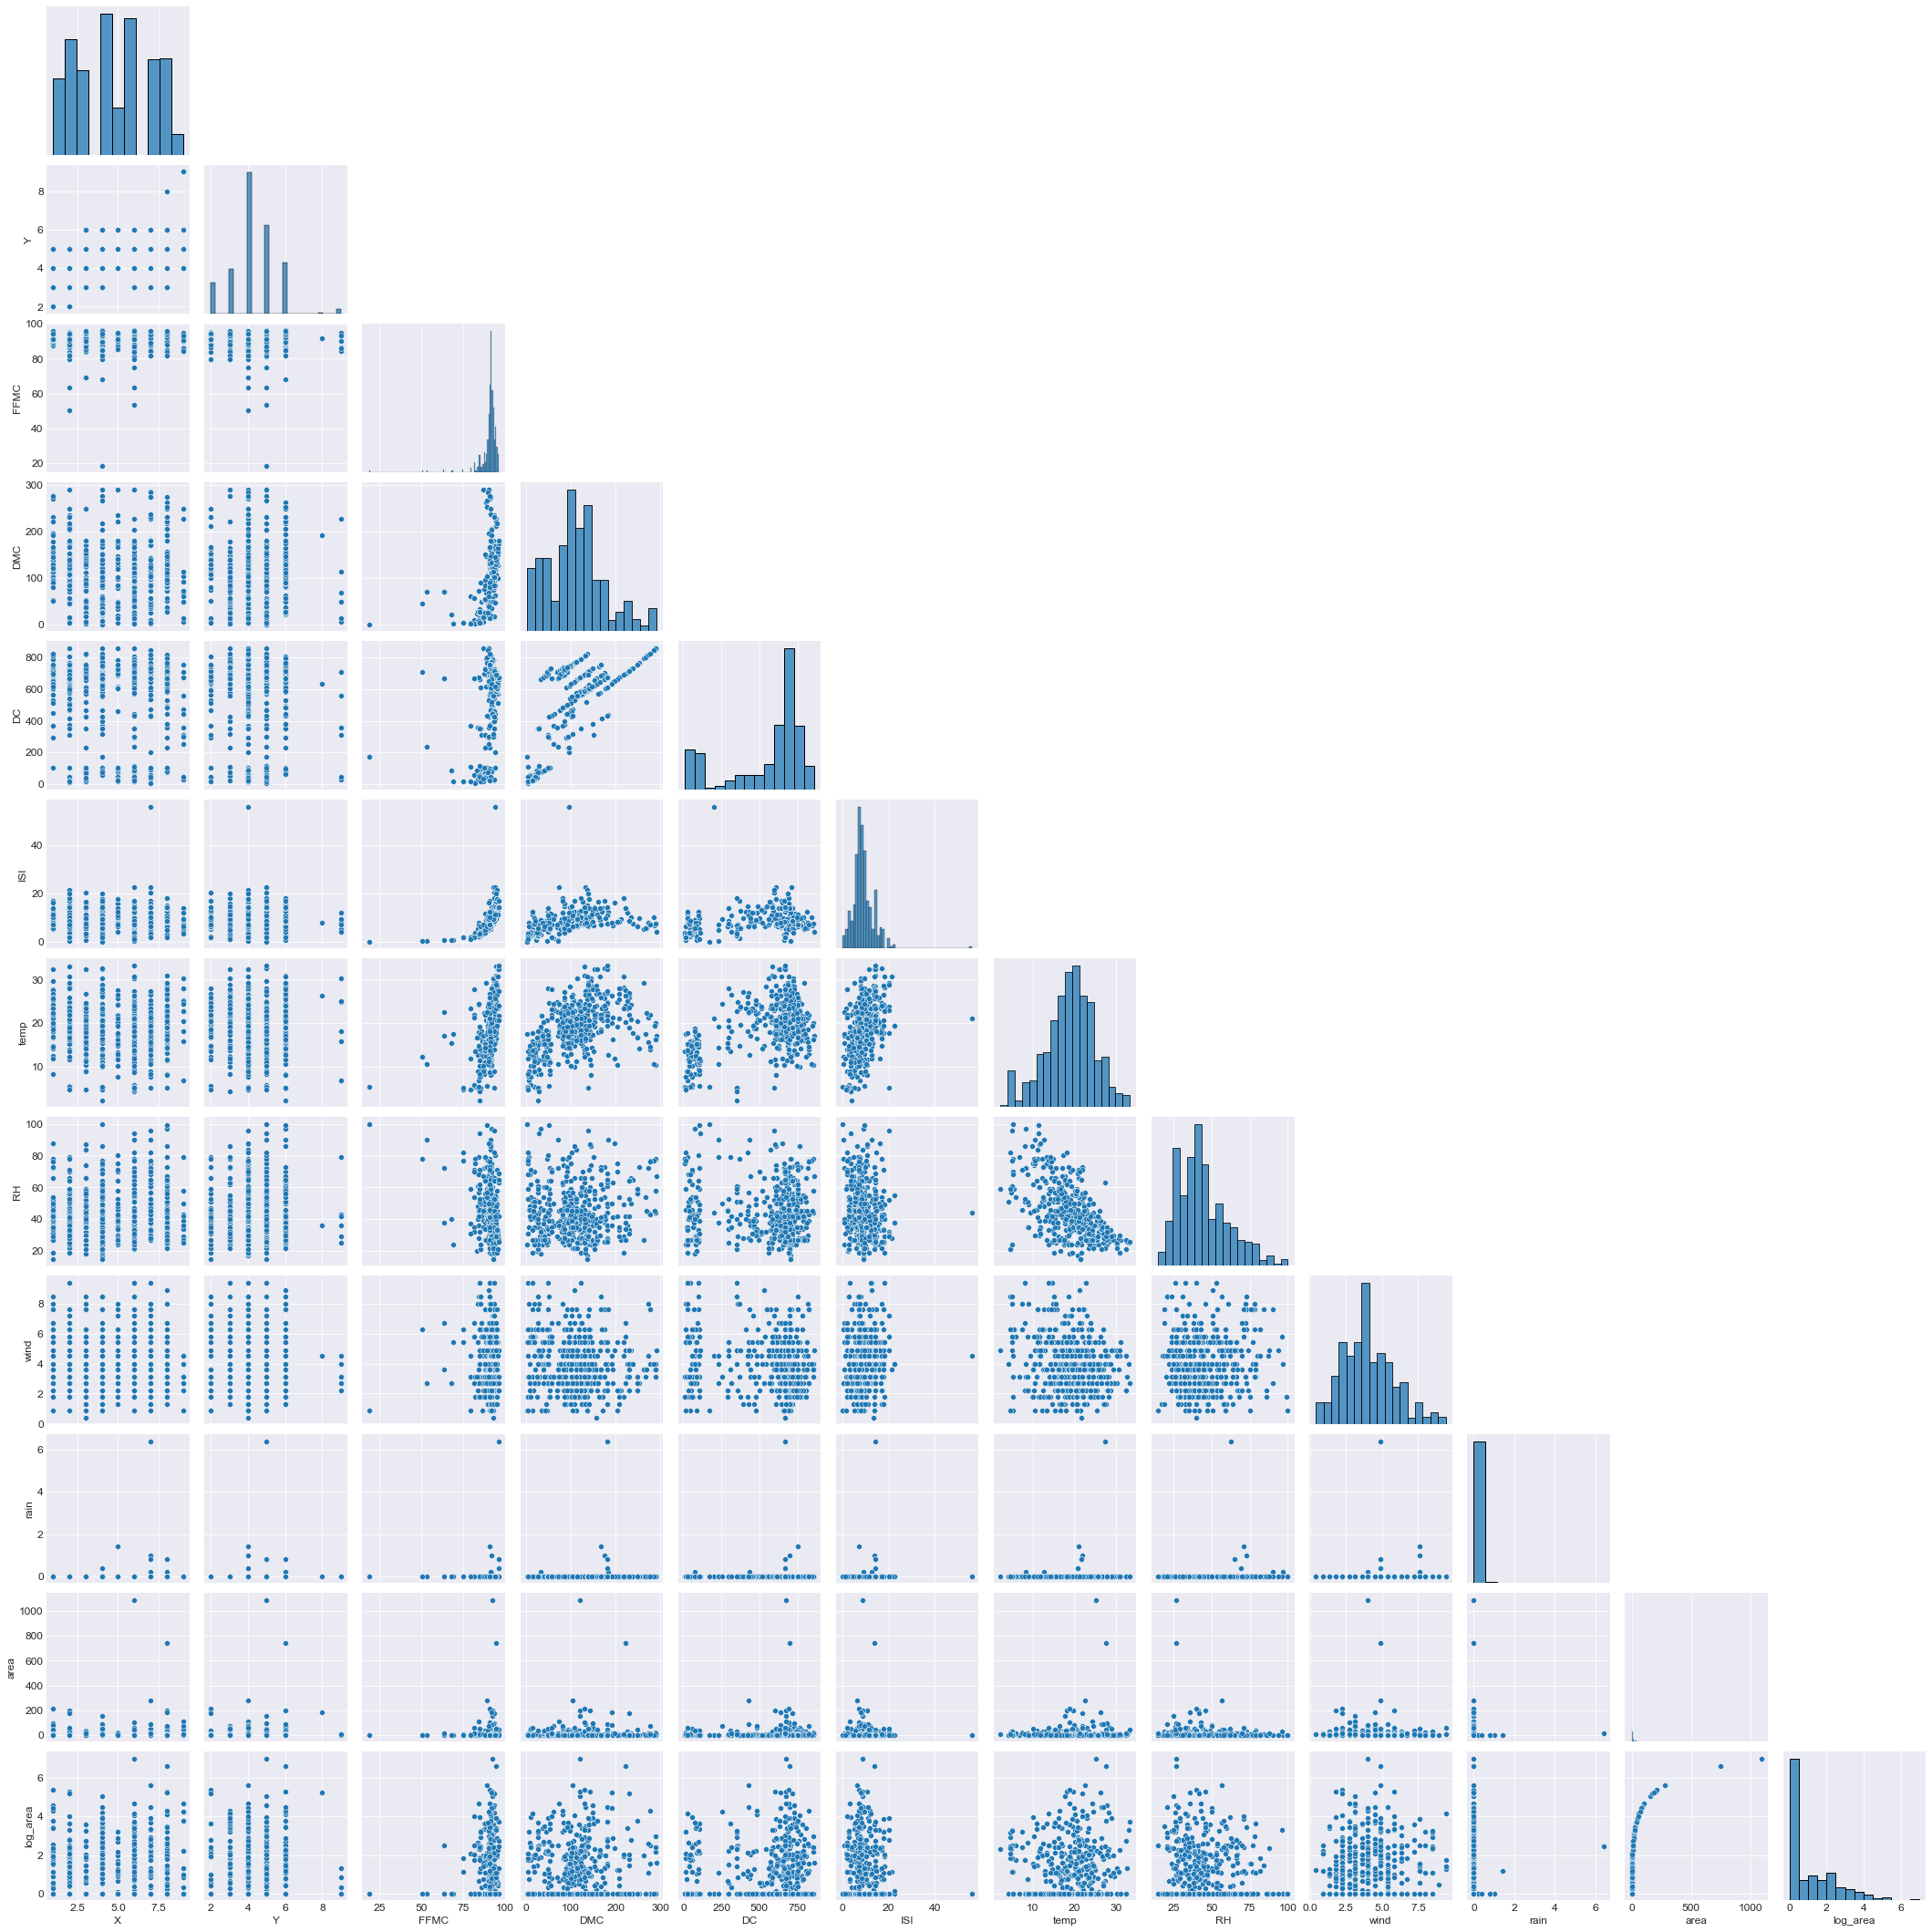

In [75]:
sns.pairplot(data=forest_fires, palette='rocket', corner=True);

**Observations**: The numerical fire-specific variables (FFMC, DMC, DC, and ISI) unsurprisingly have some sort of relationship to one another, and temperature seems to be correlated with these variables as well. FFMC is exponentially associated with ISI since ISI is composed of FFMC and wind. For FMCC, DMC, and DC, according to Cortez and Morais,

> Although different scales are used for each of the FWI elements, high values suggest more severe burning conditions. Also,the fuel moisture codes require a memory (time lag) of past weather conditions: 16hours for FFMC, 12 days for DMC and 52 days for DC.

It is difficult to tell if there is any correlation of variables with area because the distribution is so skewed towards 0. As the kaggle page suggests, we will use a logarithmic transform to grasp a better understanding of area.

In [76]:
forest_fires['log_area'] = np.log(forest_fires['area'] + 1)
forest_fires['log_area'].describe()


count    513.000000
mean       1.113081
std        1.397685
min        0.000000
25%        0.000000
50%        0.431782
75%        2.024193
max        6.995620
Name: log_area, dtype: float64

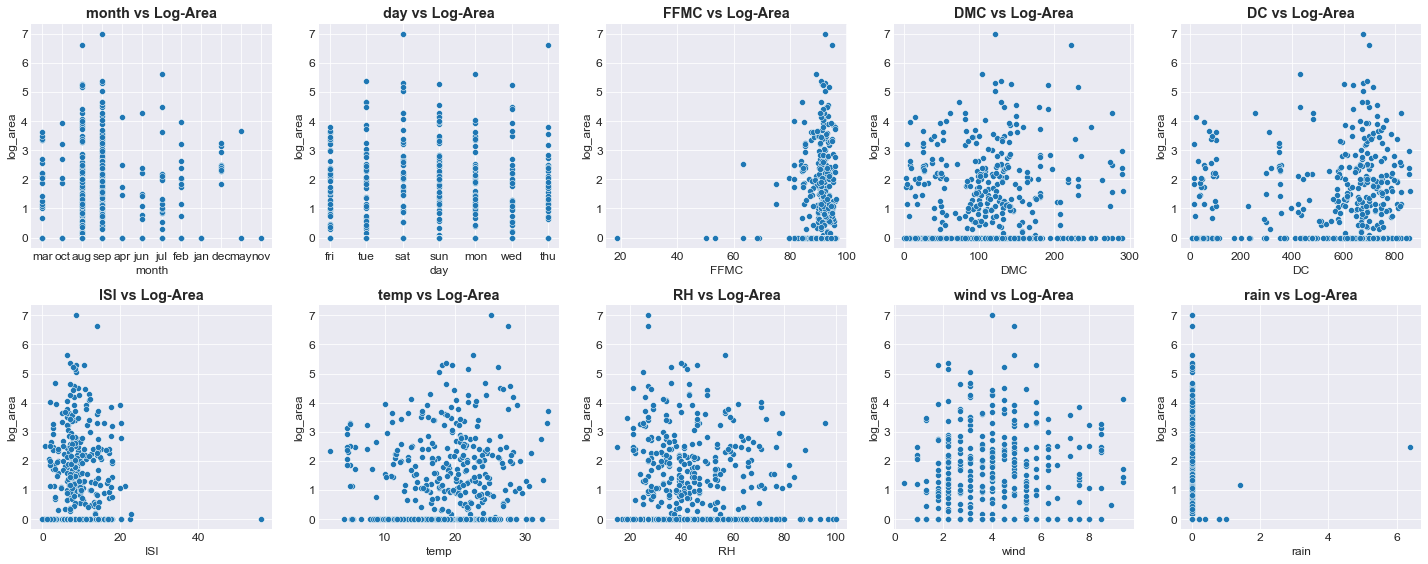

In [77]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for n, col in enumerate(forest_fires.drop(columns=['X', 'Y', 'area', 'log_area']).columns):
    ax_n = ax[n // 5][n % 5]
    
    sns.scatterplot(data=forest_fires, x=col, y='log_area', ax=ax_n)
    ax_n.set_title(f'{col} vs Log-Area')
plt.tight_layout()

There appears to be a higher concentration of observations in the months of August and September. There is also unsurprisingly a higher concentration of fires when there is no rain. More destructive fires occur when FFMC is high, but when ISI is low. DMC has a higher concentration of destructive fires in values between 50 and 150, while DC has this in values between 600 and 800. There is very little correlation between the log of area burned and temperature, wind, and relative humidity.

### Descriptive Analysis: Question
Which areas of the park tend to have more hectares burned?

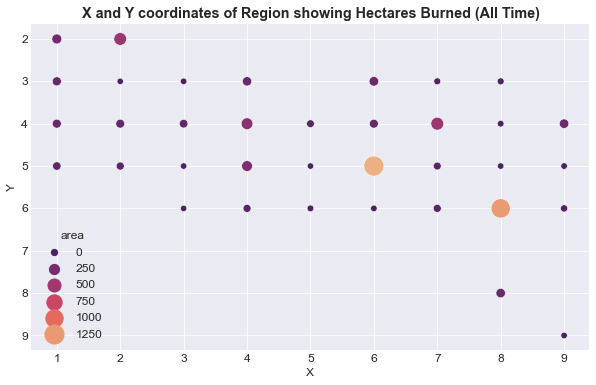

In [84]:
plt.figure(figsize=(10, 6))

fires_map = forest_fires.groupby(['X', 'Y'], as_index=False)['area'].sum()

sns.scatterplot(data=fires_map, x='X', y='Y', hue='area', size='area', palette='flare_r', sizes=(40, 400))
plt.gca().invert_yaxis()
plt.title('X and Y coordinates of Region showing Hectares Burned (All Time)');

The south-eastern section, particularly in quadrants (6, 5) and (8, 6), appear to suffer the most damage of all the areas from all time.

### Descriptive Analysis: Question
What is the relationship between FMCC and ISI? How many destructive fires occur when these values increase?

In [88]:
def create_scatter_with_hue(dataset, x, y, hue):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=dataset, x=x, y=y, hue=hue, palette='flare_r')
    plt.title(f'{x} vs. {y}');

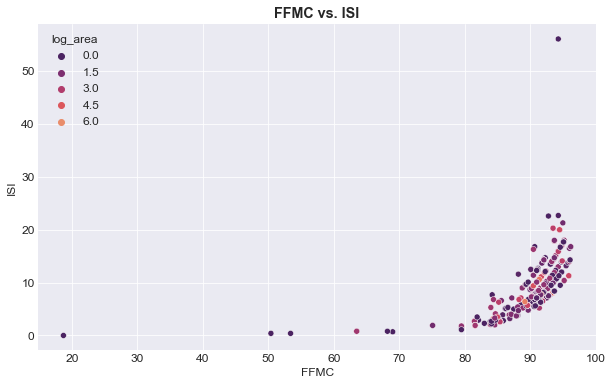

In [89]:
create_scatter_with_hue(forest_fires, x='FFMC', y='ISI', hue='log_area')

There's a small, positive exponential curve when plotting FFMC vs. ISI, and the log(area) burned does not show a very clear pattern.

In [83]:
forest_fires.loc[forest_fires['ISI'] > 50]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
22,7,4,jun,sun,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.0,0.0


The above observation is the lone outlier point in the plot above. I am not sure why the value of ISI is so high compared to the rest of the dataset.

### Descriptive Analysis: Question
What is the relationship between FMCC and wind? How many destructive fires occur when these values increase?

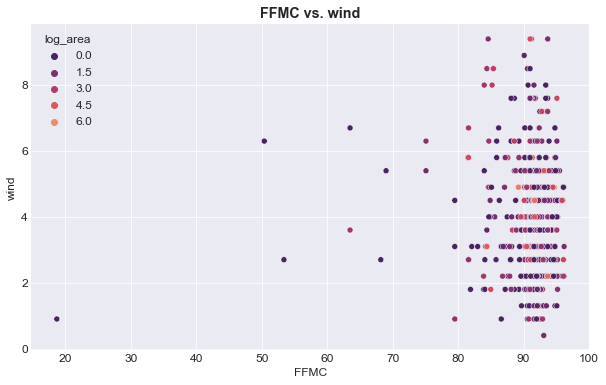

In [90]:
create_scatter_with_hue(forest_fires, x='FFMC', y='wind', hue='log_area')

Similarly to the plot above, it's hard to distinguish any kind of pattern between the destructive fires and the FMCC/wind relationship. There doesn't even really appear to be a clear relationship between FMCC and wind.

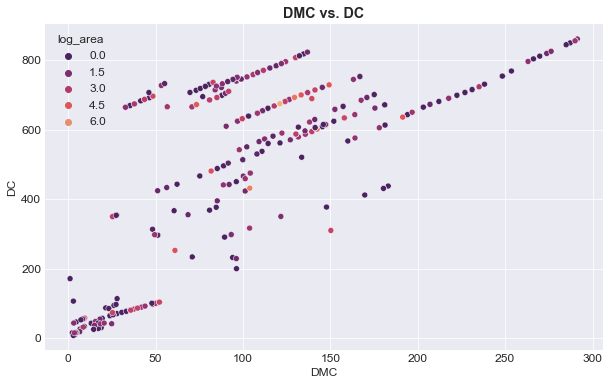

In [91]:
create_scatter_with_hue(forest_fires, x='DMC', y='DC', hue='log_area')

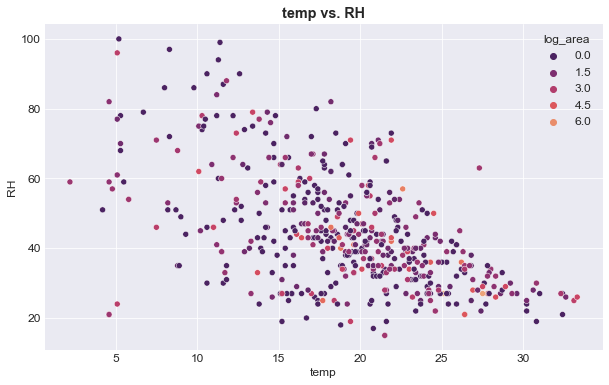

In [92]:
create_scatter_with_hue(forest_fires, x='temp', y='RH', hue='log_area')

In [112]:
months = [
    'jan',
    'feb',
    'mar',
    'apr',
    'may',
    'jul',
    'aug',
    'sep',
    'oct',
    'nov',
    'dec'
]
forest_fires['month'] = pd.Categorical(forest_fires['month'], categories=months, ordered=True)

days = [
    'sun',
    'mon',
    'tue',
    'wed',
    'thu',
    'fri',
    'sat'
]
forest_fires['day'] = pd.Categorical(forest_fires['day'], categories=days, ordered=True)


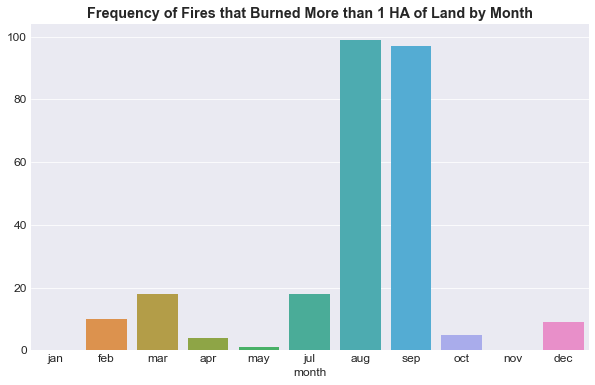

In [113]:
FIRES = forest_fires['area'] > 0
fires_by_month = forest_fires[FIRES].groupby('month').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_month.index, y=fires_by_month)
plt.title('Frequency of Fires that Burned More than 1 HA of Land by Month');

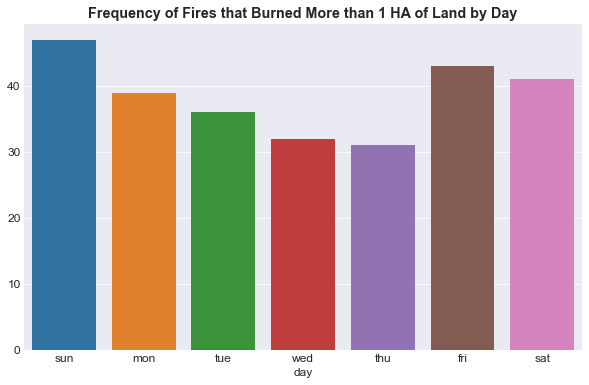

In [115]:
FIRES = forest_fires['area'] > 0
fires_by_day = forest_fires[FIRES].groupby('day').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=fires_by_day.index, y=fires_by_day)
plt.title('Frequency of Fires that Burned More than 1 HA of Land by Day');

## Data Preprocessing
---